In [1]:
from itertools import zip_longest
from math import ceil
import datetime as dt
import requests
import json

from typing import Optional, List, Dict, Iterable, Tuple
from pandas.core.frame import DataFrame

import numpy as np
import praw
from psaw import PushshiftAPI
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

sns.set()

TODO list:

1. Get all flaired submissions in a week
2. Check for duplicates (once)
3. Parse the response, get id, use PRAW to get post info
4. Filter by flair
5. Run over various weeks, combine

In [2]:
def chunker(seq: Iterable, size: int) -> Iterable:
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [3]:
# reddit = praw.Reddit(client_id='TiogCJcLNTKaXQ', 
#                      client_secret='vtroPTNpBpqh2Qze5umXTlpmh7A', 
#                      username='Moral_Judgement_Bot', 
#                      password='A not very secure password.',
#                      user_agent='AITA bot test script')

# api = PushshiftAPI(r=reddit)

In [4]:
def get_posts_between(start: int, end: int, field_names: Optional[List[str]] = None) -> pd.DataFrame:
    if field_names is None:
        field_names = ['id']#, 'title', 'selftext', 'score', 'author']

    # TODO: can be optimized by avoiding pandas
    api_url = 'https://api.pushshift.io/reddit/submission/search'

    req = requests.get(api_url, 
            params = {
                "subreddit": "AmITheAsshole",
                "sort": "desc",
                "sort_type": "score",
                "after": start,
                "before": end,
                "limit": 10000
            })
    
    res = json.loads(req.content)
    
    filtered = filter(
            lambda x: all(name in x.keys() for name in field_names),
            res['data']
            )

    data = list(map(
                lambda x: tuple(x[field] for field in field_names), 
                filtered
                ))
    
    df = pd.DataFrame(data, columns=field_names)
    df['name'] = 't3_' + df['id']
    
    return df

In [5]:
def request_info(names: List[str], useragent: str = 'MoralJudgementIncoming') -> List[Dict]:
    all_names = ','.join(names)
    
    res = requests.get('https://www.reddit.com/api/info.json',
            params={'id': all_names},
            headers={'User-agent': useragent})
    
    posts_info = json.loads(res.content)['data']['children']
    
#     print(len(posts_info), len(names))
    assert len(posts_info) == len(names), ValueError("Didn't get all posts' info")
    
    return posts_info

In [6]:
def get_details(names: Iterable[str]) -> pd.DataFrame:
    
    # TODO: add error handling if a chunk fails
    chunk_size = 100
    
    name_chunks = chunker(names, chunk_size)

    all_info = []
    
    chunk_count = ceil(len(names) / chunk_size)

    for chunk in tqdm(name_chunks, total=chunk_count):
        info = request_info(chunk)

        all_info.extend(info)


    field_names = ['id', 'title', 'created', 'selftext', 'score', 'edited', 'link_flair_text']

    data = list(map(
                lambda x: (x['data'][field] for field in field_names), 
                all_info
                ))

    df_new = pd.DataFrame(data, columns=field_names)
    df_new = df_new.fillna('')
    df_new = df_new.set_index('id')
    
    return df_new

In [7]:
def iterate_days(start: Tuple[int], end: Tuple[int], diff: int = 24, finer_start: Optional[Tuple[int]] = None) -> Tuple[dt.datetime, dt.datetime]:
    """
    
    Args:
        start: (year, month, day), start date
        end: (year, month, day), end date
        diff: number of hours to iterate over
        finer_start: (year, month, day), optional time to reduce the diff by half, for better granularity
    """ # TODO: somehow make it possible to change timedelta maybe
    start_dt = dt.datetime(*start)
    end_dt = dt.datetime(*end)
    
    assert start_dt < end_dt, ValueError("Start date should be before end date")
    
    current_dt = dt.datetime(*start)
    
    
    if finer_start is None:
        finer = True
        finer_dt = None
    else:
        finer = False
        finer_dt = dt.datetime(*finer_start)
    
    while current_dt != end_dt:
        start = current_dt
        end = current_dt + dt.timedelta(hours=diff)
        
        # If we're not in fine mode yet, and we passed a certain date, decrease the diff

        if not finer and current_dt >= finer_dt:
            finer = True
            diff = diff // 2
        
        current_dt = end
        yield int(start.timestamp()), int(end.timestamp())

In [8]:
def get_all_data(start: Tuple[int], 
                 end: Tuple[int], 
                 diff: int = 24, 
                 finer_start: Optional[Tuple[int]] = None,
                 save_names: Optional[str] = None, 
                 save_data: Optional[str] = None) -> pd.DataFrame:
    
    days = iterate_days(start, end, diff, finer_start)

    df_list = []

    num_days = (dt.datetime(*end) - dt.datetime(*start)).days
    
    if finer_start is not None:
        num_days += (dt.datetime(*end) - dt.datetime(*finer_start)).days

    print("Downloading post names from pushshift API")
    
    for start, end in tqdm(days, total=num_days):
        df_part = get_posts_between(start=start, end=end)
        df_list.append(df_part)

#     plt.plot(list(map(lambda x: x.name.shape[0], df_list)))

    all_names = np.concatenate(list(map(lambda df: df.name.values, df_list)))

    if save_names is not None:
        with open(save_names, 'w') as f:
            for name in all_names:
                f.write(name)

    print("Downloading post details from reddit API")
    
    df_full = get_details(all_names)

    if save_data is not None:
        df_full.to_csv(save_data)
        
    return df_full

In [9]:
df_full = get_all_data(start = (2018, 9, 1),
                       end = (2019, 8, 20), 
                       diff = 24,
                       finer_start = (2019, 5, 1), 
                       save_names = 'new_names.txt',
                       save_data = 'new_data.csv'
                      )

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/2082 [00:00<?, ?it/s]

100%|██████████| 2082/2082 [43:55<00:00,  1.27s/it]


In [8]:
# df_full = pd.read_csv('all_data.csv')

In [12]:
df_filtered = df_full[~df_full['selftext'].isin(['[removed]', '[deleted]'])]

In [14]:
df_filtered.shape

(83840, 6)

In [32]:
lengths = list(map(lambda x: len(x), df_filtered.selftext))

In [ ]:
df_filtered.apply()

(0, 5000)

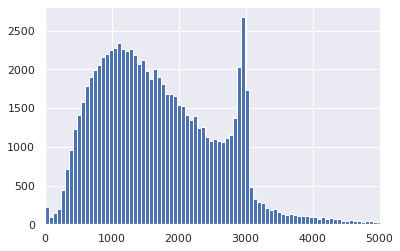

In [25]:
plt.hist(list(map(lambda x: len(x), df_filtered.selftext)), bins=500)
plt.xlim((0, 5000))

In [35]:
counts = df_filtered.groupby('link_flair_text').count()[['title']]

In [17]:
counts[counts > 100].dropna().astype(int)

,title
link_flair_text,
,409
Asshole,16956
Everyone Sucks,5378
No A-holes here,10994
Not enough info,2243
Not the A-hole,46133
Shitpost,228
TL;DR,181
asshole,204


In [46]:
df_labels = df_filtered[df_filtered['link_flair_text'].isin(['Asshole', 'Everyone Sucks', 'Not the A-hole', 'No A-holes here'])]